In [10]:
import os
import time

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_recall_curve, log_loss
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeRegressor

import tensorflow as tf
import lightgbm as lgb
import xgboost as xgb
import optuna

import utils

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [11]:
# Import data 
game_state_20, game_state_40, game_state_60, game_state_80, game_state_100 = utils.get_inputs()

# Pick one of the datasets
selected_dataset = game_state_80

dataset = selected_dataset.copy()
# Apply already tested feature transformations
utils.feature_transform(dataset)

dataset.describe().T


,count,mean,std,min,25%,50%,75%,max
blueChampionKill,64556.0,22.065757,10.876772,0.000000,15.000000,22.0,29.000000,79.000000
blueFirstBlood,64556.0,0.487035,0.499836,0.000000,0.000000,0.0,1.000000,1.000000
blueDragonKill,64556.0,1.391815,1.119721,0.000000,0.000000,1.0,2.000000,7.000000
blueDragonElderKill,64556.0,0.002742,0.055174,0.000000,0.000000,0.0,0.000000,3.000000
blueRiftHeraldKill,64556.0,0.906794,0.769593,0.000000,0.000000,1.0,2.000000,2.000000
blueBaronKill,64556.0,0.175336,0.409181,0.000000,0.000000,0.0,0.000000,4.000000
blueTowerKill,64556.0,3.904083,2.557119,0.000000,2.000000,4.0,6.000000,15.000000
blueInhibitorKill,64556.0,0.167436,0.482056,0.000000,0.000000,0.0,0.000000,8.000000
blueAvgPlayerLevel,64556.0,11.637632,3.174471,1.000000,10.600000,12.2,13.600000,18.000000
blueWin,64556.0,0.504910,0.499980,0.000000,0.000000,1.0,1.000000,1.000000


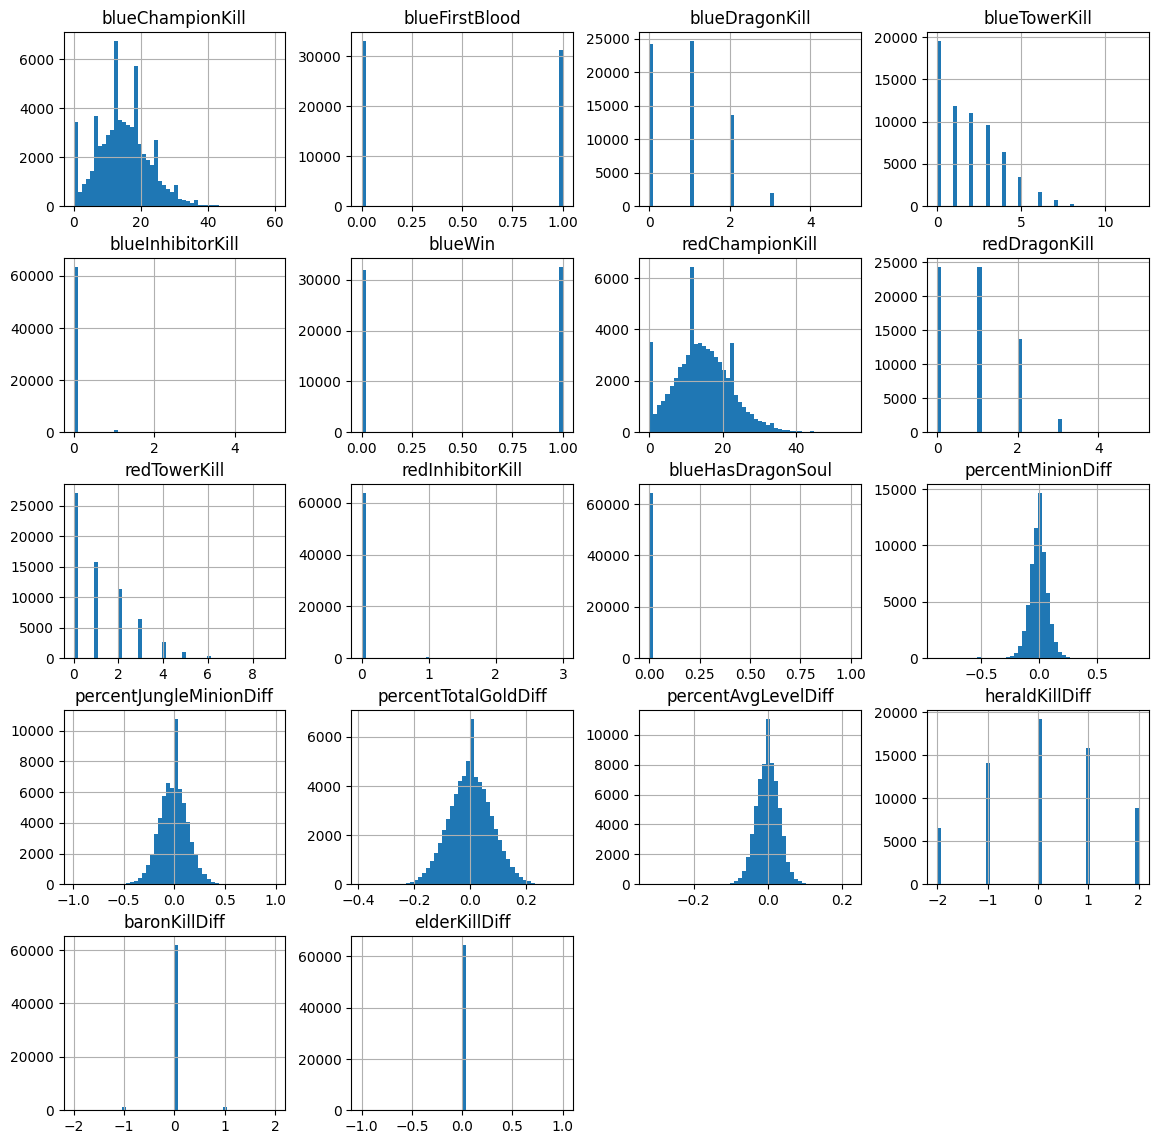

In [4]:
# Visualize data
# Look at feature hists

dataset.hist(bins=50, figsize=(14,14))
plt.show()

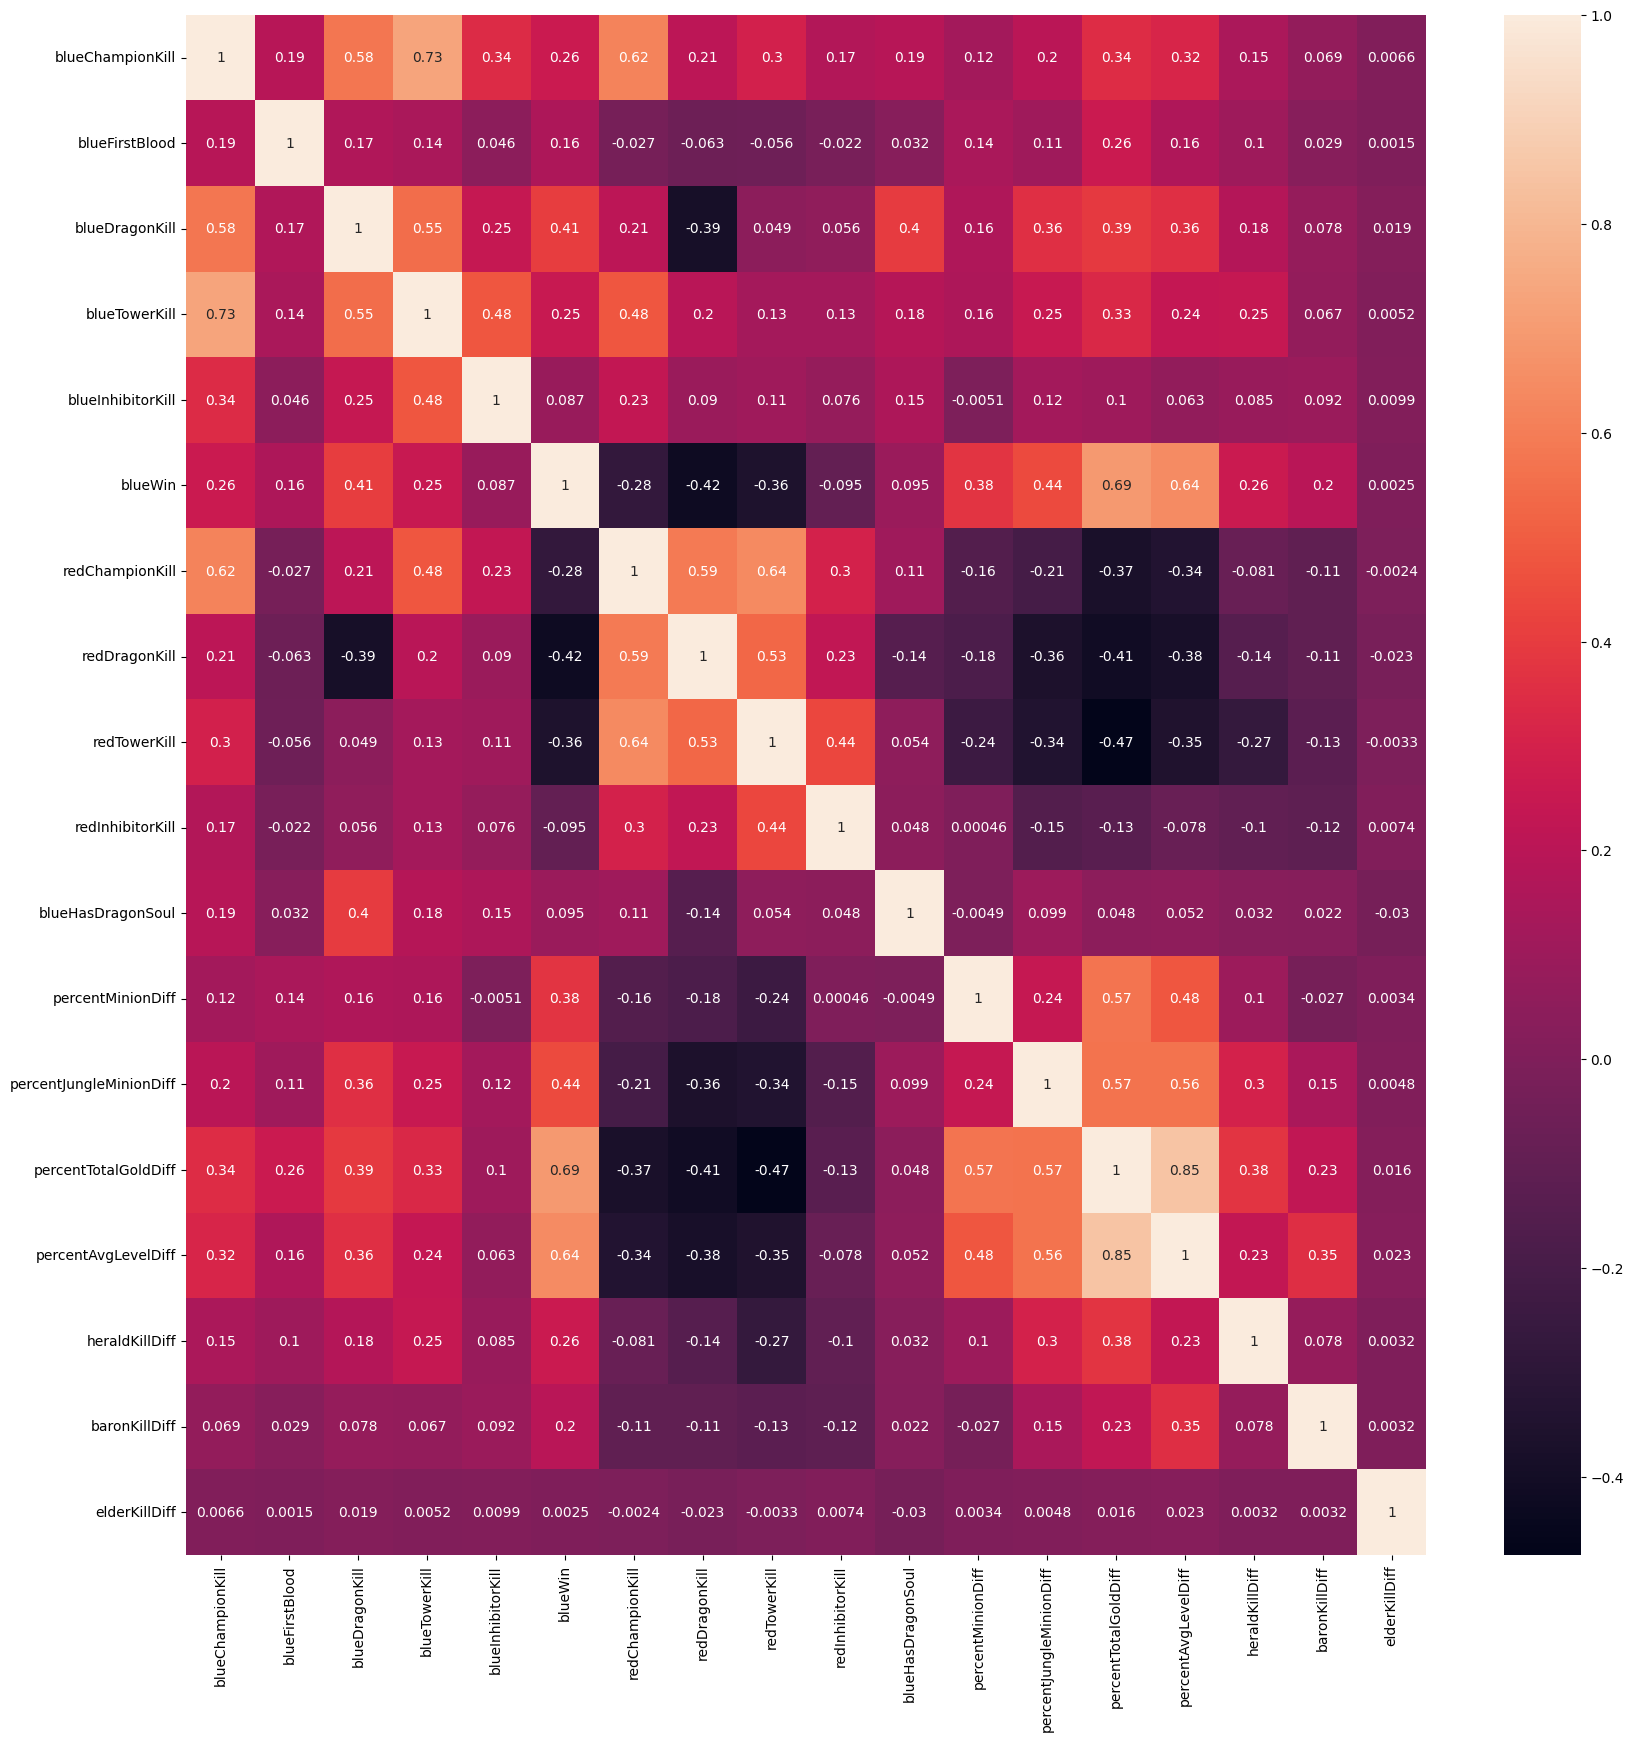

In [7]:
# Look at correlations
corr_matrix = dataset.corr()
corr_plot , corr_ax = plt.subplots(figsize=(20,20))

sns.heatmap(data=corr_matrix, annot=True, ax=corr_ax)

plt.show()

In [12]:
### Feature engineering

# Use percent difference in average levels
avgLevelDiff  = dataset.blueAvgPlayerLevel - dataset.redAvgPlayerLevel
percentAvgLevelDiff = avgLevelDiff / (dataset.blueAvgPlayerLevel + dataset.redAvgPlayerLevel)

dataset.insert(len(dataset.columns), 'percentAvgLevelDiff', percentAvgLevelDiff)

# Combine blue and red dragon soul, 1 if blue, -1 if red, 0 if neither
for idx, row in dataset.iterrows():
    if row['redHasDragonSoul'] == 1:
        row['blueHasDragonSoul'] = -1

# Combine neutral objectives to differences
heraldKillDiff = dataset.blueRiftHeraldKill - dataset.redRiftHeraldKill
baronKillDiff = dataset.blueBaronKill - dataset.redBaronKill
elderKillDiff = dataset.blueDragonElderKill - dataset.redDragonElderKill

dataset.insert(len(dataset.columns), 'heraldKillDiff', heraldKillDiff)
dataset.insert(len(dataset.columns), 'baronKillDiff', baronKillDiff)
dataset.insert(len(dataset.columns), 'elderKillDiff', elderKillDiff)

# Remove combined features
cut_features = ['blueAvgPlayerLevel',
                'redAvgPlayerLevel',
                'redHasDragonSoul',
                'blueRiftHeraldKill',
                'blueBaronKill',
                'blueDragonElderKill',
                'redRiftHeraldKill',
                'redBaronKill',
                'redDragonElderKill',
               ]

dataset.drop(columns=cut_features, inplace=True)



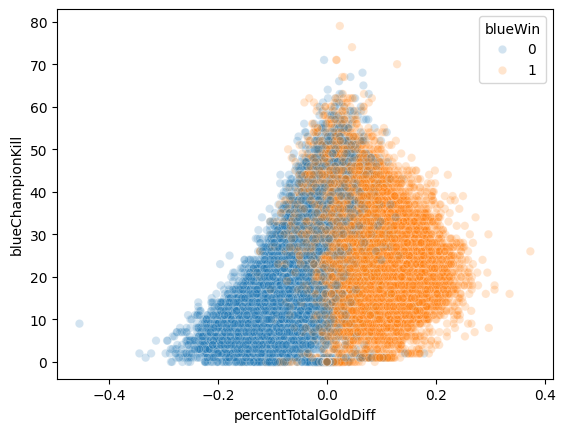

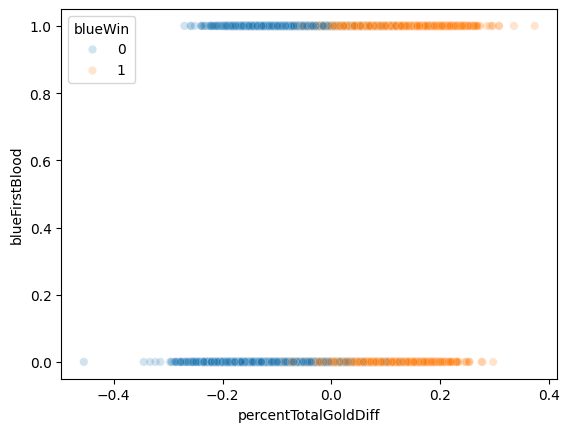

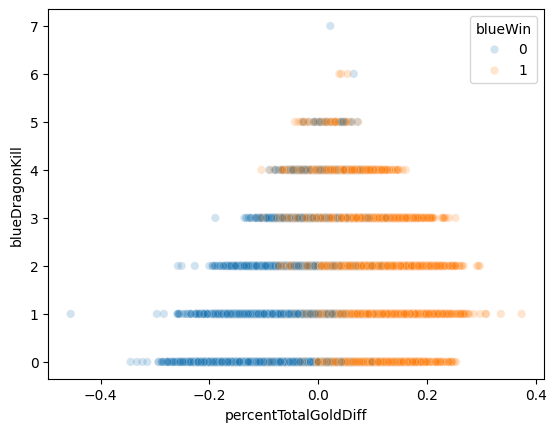

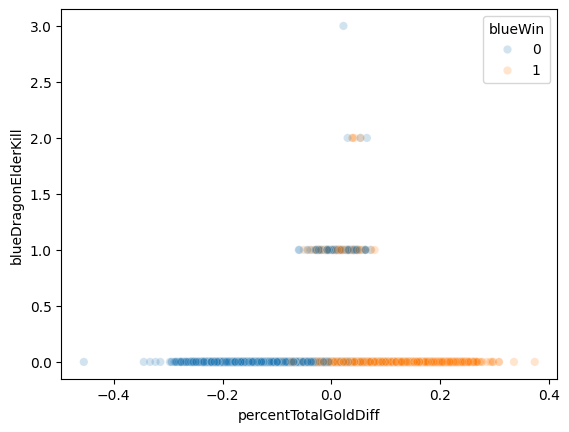

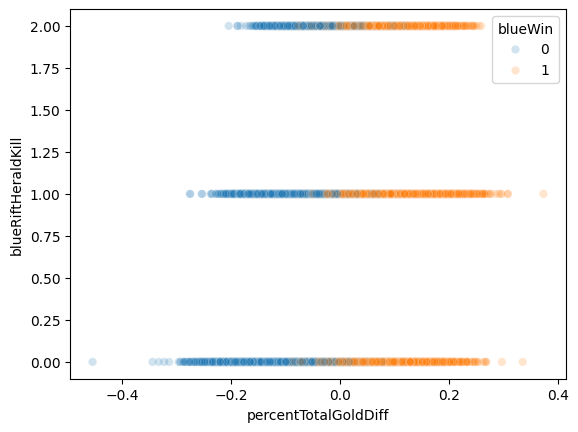

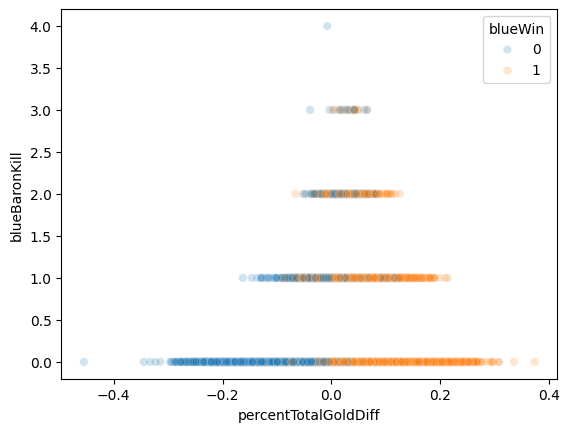

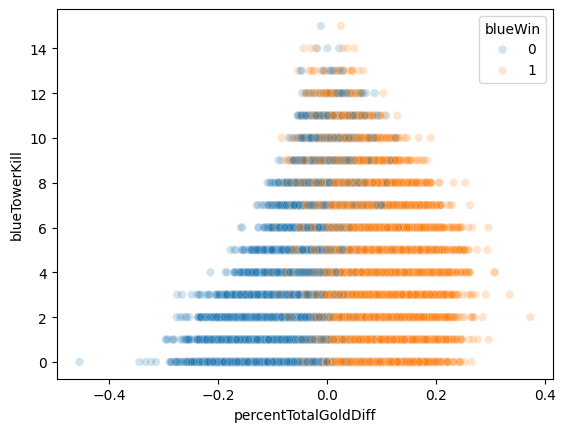

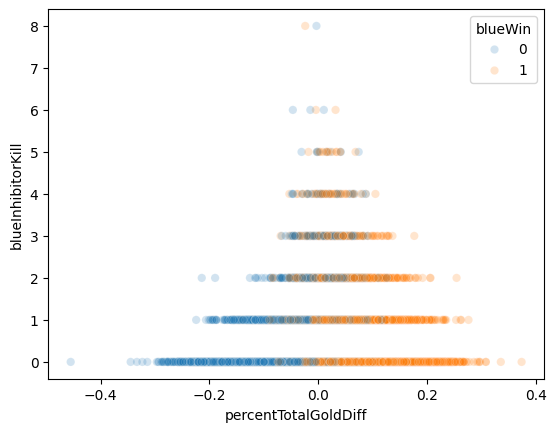

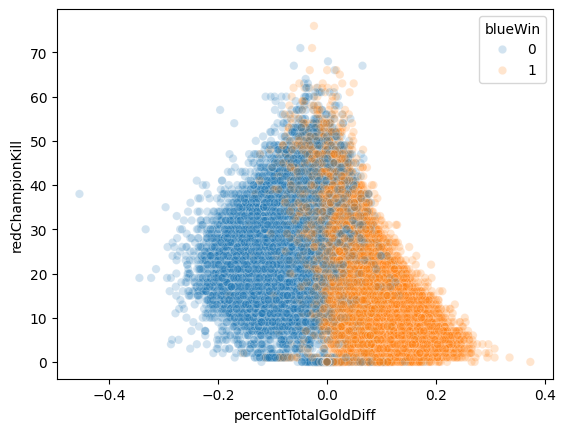

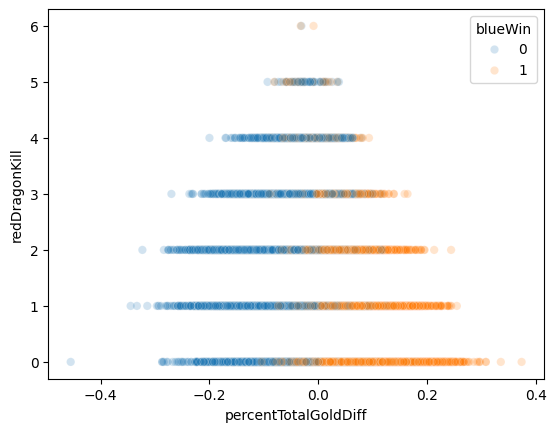

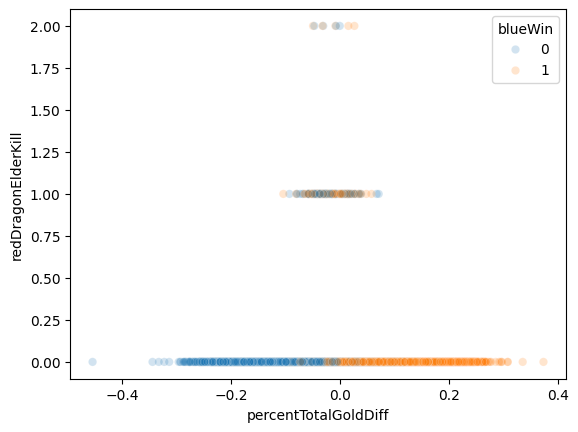

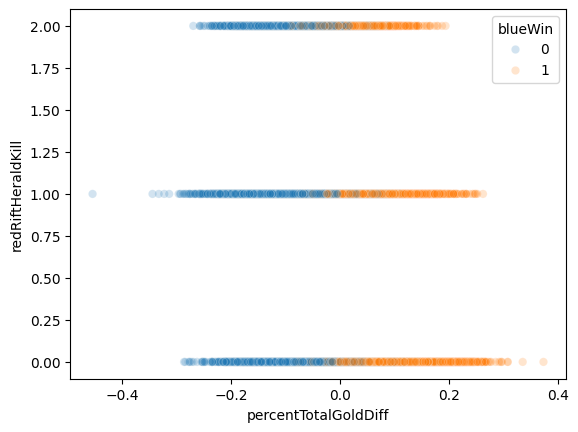

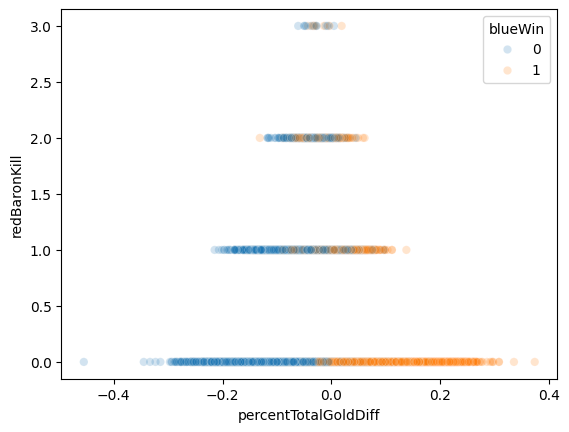

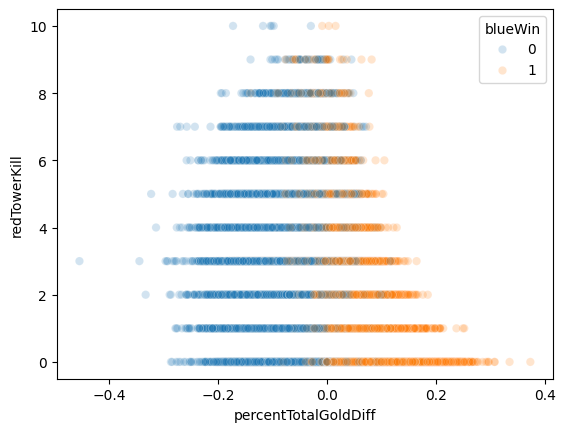

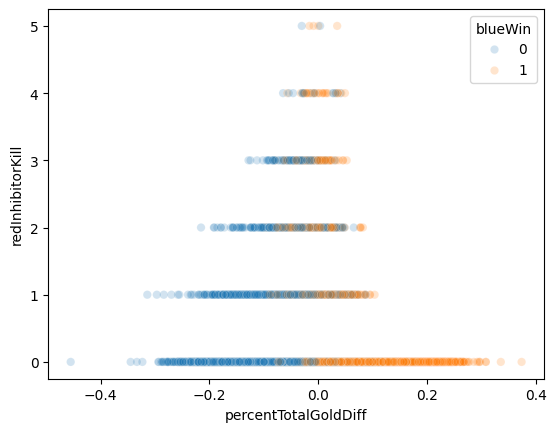

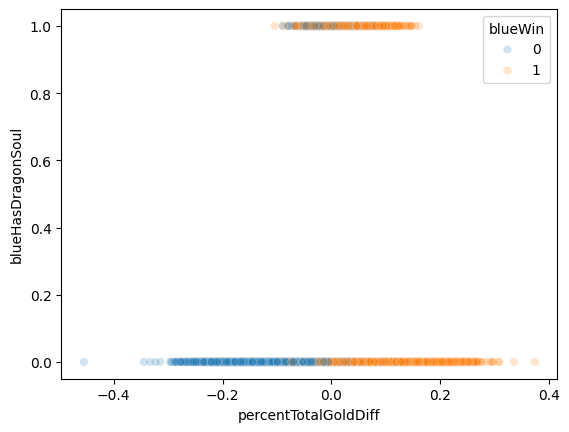

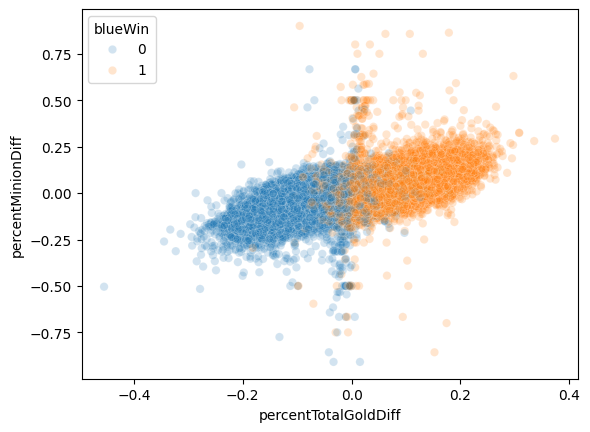

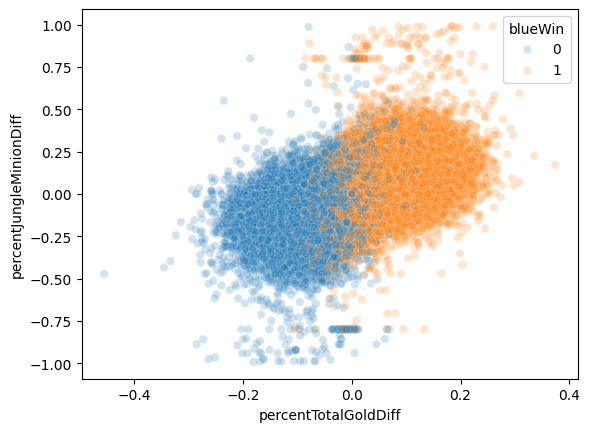

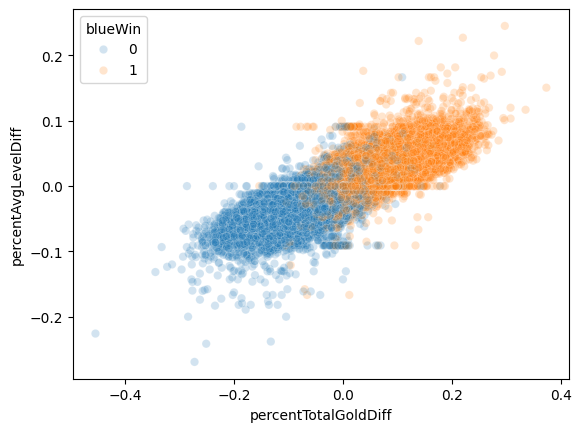

In [36]:
# Look at correlation scatterplots
utils.corr_scatter_plot(dataset, dataset.percentTotalGoldDiff, dataset.blueWin, alpha=0.2)

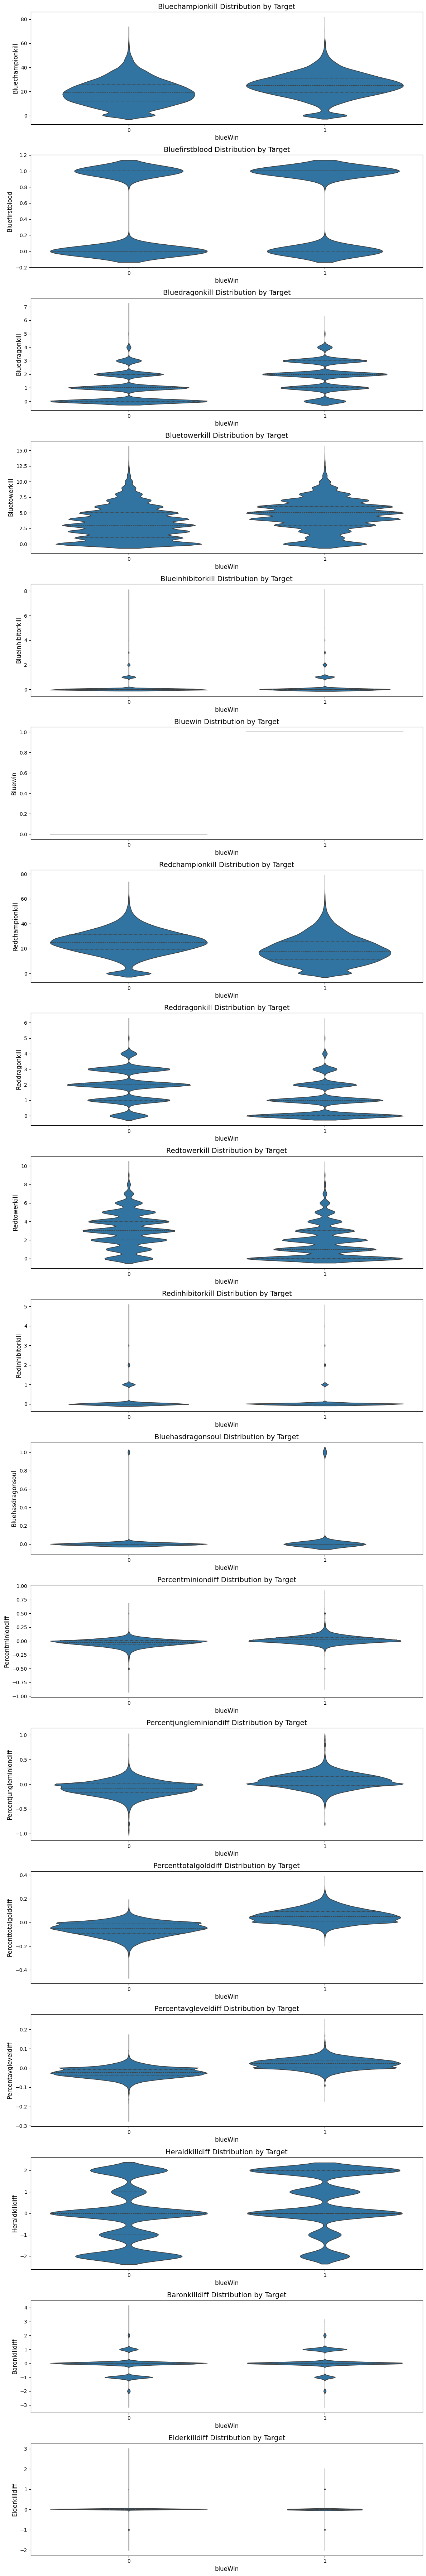

In [8]:
# Compare features based on win/loss
utils.binary_comparison_plot(dataset, 'blueWin')

In [13]:
# Prepare training and validation sets and labels

valid_frac = 0.2

train_set, valid_set = train_test_split(dataset, test_size=valid_frac, random_state=RANDOM_SEED)

# Separate wins
train_wins = train_set.pop('blueWin')
valid_wins = valid_set.pop('blueWin')


print(dataset.shape, train_set.shape, valid_set.shape)


(64556, 18) (51644, 17) (12912, 17)


In [14]:
# Try logistic regression, SGD classifier and decision tree regressor with scikit-learn

# Initialize models
sgd_model = SGDClassifier(loss='log_loss', penalty='l2')
lr_model = LogisticRegression()
dtr_model = DecisionTreeRegressor(random_state=RANDOM_SEED)

# Fit to training data
sgd_model.fit(train_set, train_wins)
lr_model.fit(train_set, train_wins)
dtr_model.fit(train_set, train_wins)

# Compute predictions for training and validation set
sgd_train_pred = sgd_model.predict(train_set)
sgd_valid_pred = sgd_model.predict(valid_set)
lr_train_pred = lr_model.predict(train_set)
lr_valid_pred = lr_model.predict(valid_set)
dtr_train_pred = dtr_model.predict(train_set)
dtr_valid_pred = dtr_model.predict(valid_set)

# Compute log loss
sgd_train_loss = log_loss(train_wins, sgd_train_pred)
sgd_valid_loss = log_loss(valid_wins, sgd_valid_pred)
lr_train_loss = log_loss(train_wins, lr_train_pred)
lr_valid_loss = log_loss(valid_wins, lr_valid_pred)
dtr_train_loss = log_loss(train_wins, dtr_train_pred)
dtr_valid_loss = log_loss(valid_wins, dtr_valid_pred)

print(sgd_train_loss, sgd_valid_loss, lr_train_loss, lr_valid_loss, dtr_train_loss, dtr_valid_loss)

NameError: name 'DecisionTreeRegressor' is not defined

In [13]:
# Try ANN with tensorflow

# Convert dataframes to tensors
train_data = tf.convert_to_tensor(train_set, dtype='float32')
train_labels = tf.convert_to_tensor(train_wins, dtype='float32')

valid_data = tf.convert_to_tensor(valid_set, dtype='float32')
valid_labels = tf.convert_to_tensor(valid_wins, dtype='float32')

input_shape = [train_data.shape[1]]

# Define NN
dnn = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=input_shape),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Choose optimizer and loss function
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001)
loss_func = tf.keras.losses.BinaryCrossentropy()

# Compile and train model
dnn.compile(optimizer=optimizer, loss = loss_func, metrics=['binary_accuracy'])
dnn.fit(x=train_data, y=train_labels, epochs = 100, batch_size=64)

# Test model
dnn.evaluate(valid_data, valid_labels)

Epoch 1/100
807/807 [==============================] - 10s 10ms/step - loss: 0.3776 - binary_accuracy: 0.8240
Epoch 2/100
807/807 [==============================] - 10s 13ms/step - loss: 0.3371 - binary_accuracy: 0.8358
Epoch 3/100
807/807 [==============================] - 9s 11ms/step - loss: 0.3346 - binary_accuracy: 0.8378
Epoch 4/100
807/807 [==============================] - 8s 10ms/step - loss: 0.3347 - binary_accuracy: 0.8378
Epoch 5/100
807/807 [==============================] - 7s 9ms/step - loss: 0.3336 - binary_accuracy: 0.8388
Epoch 6/100
807/807 [==============================] - 7s 9ms/step - loss: 0.3311 - binary_accuracy: 0.8409
Epoch 7/100
807/807 [==============================] - 7s 9ms/step - loss: 0.3318 - binary_accuracy: 0.8385
Epoch 8/100
807/807 [==============================] - 8s 10ms/step - loss: 0.3311 - binary_accuracy: 0.8393
Epoch 9/100
807/807 [==============================] - 7s 9ms/step - loss: 0.3300 - binary_accuracy: 0.8400
Epoch 10/100
807/807 

[0.34075796604156494, 0.8429368138313293]

In [33]:
# Try gradient boost with XGB

# Convert pandas dataframes to xgb DMatrices
train_dm = xgb.DMatrix(train_set, train_wins)
valid_dm = xgb.DMatrix(valid_set, valid_wins)

# Set hyperparameters
xgb_params = {'objective': 'binary:logistic',
              'tree_method': 'hist',
              'learning_rate': 0.1,
              'eval_metric': 'logloss',
              'max_depth': 6,
              'subsample': 0.8,
              'colsample_bytree': 1,
              'verbosity': 2
            }
evals = [(train_dm, 'train'), (valid_dm, 'validation')]

# Train model
xgb_results = xgb.cv(params=xgb_params,
                     dtrain=train_dm,
                     verbose_eval=10,
                     early_stopping_rounds=10,
                     nfold=10,
                     metrics=['auc', 'error'],
                     num_boost_round=1000)

xgb_results.head(10)



[0]	train-auc:0.93221+0.00059	train-error:0.15575+0.00129	test-auc:0.92802+0.00336	test-error:0.16116+0.00528
[10]	train-auc:0.93928+0.00038	train-error:0.14873+0.00068	test-auc:0.93431+0.00352	test-error:0.15608+0.00350
[20]	train-auc:0.94103+0.00040	train-error:0.14751+0.00068	test-auc:0.93517+0.00356	test-error:0.15456+0.00387
[30]	train-auc:0.94220+0.00042	train-error:0.14686+0.00064	test-auc:0.93559+0.00357	test-error:0.15411+0.00418
[35]	train-auc:0.94259+0.00043	train-error:0.14663+0.00058	test-auc:0.93569+0.00360	test-error:0.15388+0.00350


,train-auc-mean,train-auc-std,train-error-mean,train-error-std,test-auc-mean,test-auc-std,test-error-mean,test-error-std
0,0.932210,0.000594,0.155753,0.001288,0.928025,0.003358,0.161158,0.005278
1,0.935085,0.000529,0.152081,0.001092,0.930615,0.003523,0.158951,0.004869
2,0.936211,0.000461,0.151055,0.001202,0.931510,0.003596,0.158002,0.003950
3,0.937012,0.000478,0.150560,0.001089,0.932387,0.003501,0.157189,0.003403
4,0.937494,0.000450,0.150080,0.001022,0.932697,0.003439,0.156859,0.003541
5,0.937879,0.000464,0.149714,0.001061,0.933065,0.003364,0.157479,0.003379
6,0.938287,0.000421,0.149271,0.000899,0.933555,0.003544,0.156762,0.003535
7,0.938580,0.000380,0.149088,0.000714,0.933823,0.003545,0.156550,0.003495
8,0.938810,0.000369,0.148929,0.000890,0.934013,0.003550,0.156453,0.003422
9,0.939067,0.000370,0.148854,0.000747,0.934210,0.003555,0.156259,0.003589
